# Chartevents ItemID Selection
 
As one phenomenon (e.g. respiratory rate) is liked to multiple item ID's (e.g. 220210, 224688) in the MIMIC dataset, we face the problem of having multiple values for one measurement within one timeframe. As we  continue data analysis with a Pivot Table, we need to decide on a single Item ID to represent a measurement (e.g. respiratory rate). 

##### Import relevant libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##### Import relevant table: chartevents

In [2]:
df_charts = pd.read_csv('data/chartevents_pre_extub.csv')

In [3]:
df_charts.head()

,hadm_id,icustay_id,itemid,charttime,value,valuenum,valueuom,item,storetime,cgid,warning,error,resultstatus,stopped
0,100016.0,217590.0,220045.0,2188-05-28 08:00:00,91,91.0,bpm,hr,2188-05-28 08:02:00,15623.0,0.0,0.0,NaN,NaN
1,100016.0,217590.0,220181.0,2188-05-28 08:00:00,88,88.0,mmHg,blood_pr,2188-05-28 08:02:00,15623.0,0.0,0.0,NaN,NaN
2,100016.0,217590.0,220210.0,2188-05-28 08:00:00,18,18.0,insp/min,resp_rat,2188-05-28 08:02:00,15623.0,0.0,0.0,NaN,NaN
3,100016.0,217590.0,220277.0,2188-05-28 08:00:00,100,100.0,%,SaO2,2188-05-28 08:02:00,15623.0,0.0,0.0,NaN,NaN
4,100016.0,217590.0,220339.0,2188-05-28 08:00:00,5,5.0,cmH2O,PEEP,2188-05-28 07:36:00,20803.0,0.0,0.0,NaN,NaN


In [4]:
first_shape = df_charts.shape
first_shape

(74306, 14)

In [5]:
# Number of unique values from itemid
first_unique = df_charts.itemid.nunique()
first_unique

44

The table contains 44 different measurements. 

In [6]:
df_charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74306 entries, 0 to 74305
Data columns (total 14 columns):
hadm_id         74306 non-null float64
icustay_id      74306 non-null float64
itemid          74306 non-null float64
charttime       74306 non-null object
value           73903 non-null object
valuenum        73992 non-null float64
valueuom        59637 non-null object
item            74306 non-null object
storetime       74220 non-null object
cgid            74220 non-null float64
warning         33854 non-null float64
error           33854 non-null float64
resultstatus    11633 non-null object
stopped         40377 non-null object
dtypes: float64(7), object(7)
memory usage: 7.9+ MB


##### Import dictionary items
 
The dictionary entails the corresponding descriptions to one item ID. 

In [7]:
df_items = pd.read_csv('data/D_ITEMS.csv.gz', compression='gzip')

In [8]:
df_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,458,498,PCA Lockout (Min),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,459,499,PCA Medication,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,460,500,PCA Total Dose,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,461,501,PCV Exh Vt (Obser),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


##### Create a function to make the seperations
 
In the following, we will use this function, to select one ItemID and exclude the other ID's without loosing information of the data. The function is structured as follows: 
 
1. Print the shape of the original dataframe 
2. Choose the itemID with the most occurances as priorizized item ID and isolate the unique icu stay ID's 
3. Choose the itemID with the second most occurances as follow-up item ID and isolate the unique icu stay ID's
4. Subtract the unique icu stay ID's of the follow-up item ID from the priorizized item ID (the remainer are icu stay ID's not present in the prioritized ITEM ID). 
5. Print the common and different icu stay ID's 
6. Create a new dataframe containing the icu stay ID's of the prioritized item ID and the ones of the follow-up item ID that are not in covered by the prioritized item ID.
7. Replace the item ID of the values containing the follow-up item ID with the priorizized item ID to end up with a single item ID for the chosen measurement. 
8. Delete the rows containing the follow-up item ID in the original dataframe
9. Concat the new dataframe to the original dataframe

**Things to keep in mind**: 
* The priorizized item ID and the follow-up item ID need to have the same type of measurement 
* The priorizized item ID needs to be higher than the follow-up item ID 

In [9]:
# num1 has to be higher than num2
def exclude(num1,num2,df_charts=df_charts):
    old_shape = df_charts.shape
    print(f'Shape original dataframe:{old_shape}')
    set1= set(df_charts[df_charts.itemid==num1].icustay_id.unique())
    set2= set(df_charts[df_charts.itemid==num2].icustay_id.unique())
    x = set2 - set1
    y = set2.intersection(set1)
    print(f'Intersection: {len(y)}, Symmetric difference: {len(x)}')
    new_df = df_charts[(df_charts.itemid==num2) & (df_charts.icustay_id.isin(list(x)))]
    new_df.itemid = new_df.itemid.replace(num2,num1)
    df_charts = df_charts[df_charts.itemid!=num2]
    df_charts = pd.concat([df_charts, new_df])
    print(f'Shape new dataframe:{df_charts.shape}')
    print(f'Deleted intersecting rows:{old_shape[0]- df_charts.shape[0]}')
    return df_charts

# Blood Pressure

Source|values
:---|:---
cv| 52, 456
mv |225312, 220181, 220052

**Carevue:**

In [10]:
df_items[(df_items.ITEMID==52) | (df_items.ITEMID==456)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
321,58,52,Arterial BP Mean,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
683,420,456,NBP Mean,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


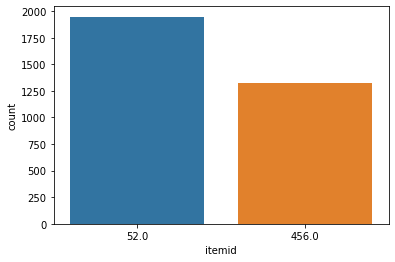

In [11]:
sns.countplot(x=df_charts[(df_charts.itemid==52) | (df_charts.itemid==456)].itemid);

In [12]:
df_charts= exclude(52,456)

Shape original dataframe:(74306, 14)
Intersection: 163, Symmetric difference: 1165
Shape new dataframe:(74143, 14)
Deleted intersecting rows:163


**Metavision**

In [13]:
df_items[(df_items.ITEMID==225312) | (df_items.ITEMID==220181) | (df_items.ITEMID==220052)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
11504,12718,220052,Arterial Blood Pressure mean,ABPm,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN
11522,12736,220181,Non Invasive Blood Pressure mean,NBPm,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN
12445,13689,225312,ART BP mean,ART BP mean,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN


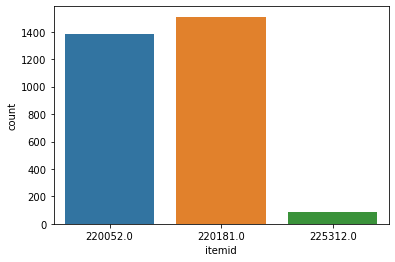

In [14]:
sns.countplot(x=df_charts[(df_charts.itemid==225312) | (df_charts.itemid==220181) | (df_charts.itemid==220052)].itemid);

In [15]:
df_charts= exclude(220181,225312,df_charts)

Shape original dataframe:(74143, 14)
Intersection: 3, Symmetric difference: 82
Shape new dataframe:(74140, 14)
Deleted intersecting rows:3


In [16]:
df_charts= exclude(220181,220052, df_charts)

Shape original dataframe:(74140, 14)
Intersection: 139, Symmetric difference: 1245
Shape new dataframe:(74001, 14)
Deleted intersecting rows:139


# Temperature

Source|values
:---|:---
cv| 676,  677
mv|  223762

In [17]:
df_items[(df_items.ITEMID==676) | (df_items.ITEMID==677)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1446,627,676,Temperature C,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1447,628,677,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


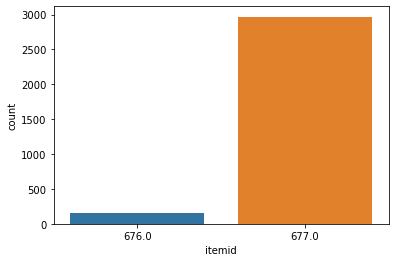

In [18]:
sns.countplot(x=df_charts[(df_charts.itemid==676) | (df_charts.itemid==677)].itemid);

In [19]:
df_charts = exclude(677,676, df_charts)

Shape original dataframe:(74001, 14)
Intersection: 10, Symmetric difference: 148
Shape new dataframe:(73991, 14)
Deleted intersecting rows:10


# SaO2

Source|values
:---|:---
cv| 646, 834
mv| 220277, 220227

**Carevue**

In [20]:
df_items[(df_items.ITEMID==646) | (df_items.ITEMID==834)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
749,1126,834,SaO2,NaN,carevue,chartevents,ABG's,NaN,NaN,NaN
1418,599,646,SpO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


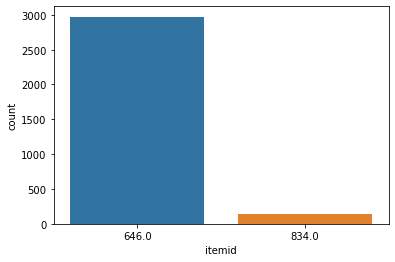

In [21]:
sns.countplot(x=df_charts[(df_charts.itemid==646) | (df_charts.itemid==834)].itemid);

In [22]:
df_charts = exclude(646,834, df_charts)

Shape original dataframe:(73991, 14)
Intersection: 5, Symmetric difference: 136
Shape new dataframe:(73986, 14)
Deleted intersecting rows:5


**Metavision**

In [23]:
df_items[(df_items.ITEMID==220277) | (df_items.ITEMID==220227)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
11527,12741,220227,Arterial O2 Saturation,SaO2,metavision,chartevents,Labs,%,Numeric,NaN
12355,12746,220277,O2 saturation pulseoxymetry,SpO2,metavision,chartevents,Respiratory,%,Numeric,NaN


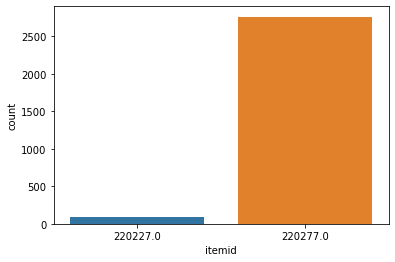

In [24]:
sns.countplot(x=df_charts[(df_charts.itemid==220277) | (df_charts.itemid==220227)].itemid);

In [25]:
df_charts = exclude(220227,220277, df_charts)

Shape original dataframe:(73986, 14)
Intersection: 2, Symmetric difference: 2761
Shape new dataframe:(73984, 14)
Deleted intersecting rows:2


# Respiratory Rate

Source|values
:---|:---
cv|618
mv| 220210, 224688

In [26]:
df_items[(df_items.ITEMID==220210) | (df_items.ITEMID==224688)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
10052,13244,224688,Respiratory Rate (Set),Respiratory Rate (Set),metavision,chartevents,Respiratory,insp/min,Numeric,NaN
11524,12738,220210,Respiratory Rate,RR,metavision,chartevents,Respiratory,insp/min,Numeric,NaN


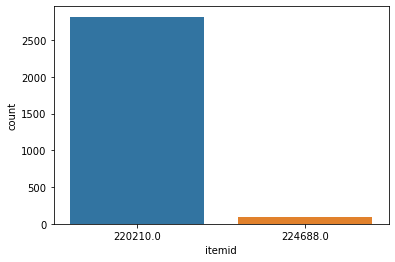

In [27]:
sns.countplot(x=df_charts[(df_charts.itemid==220210) | (df_charts.itemid==224688)].itemid);

In [28]:
df_charts = exclude(220210,224688, df_charts)

Shape original dataframe:(73984, 14)
Intersection: 72, Symmetric difference: 20
Shape new dataframe:(73912, 14)
Deleted intersecting rows:72


# Breath-Minute-Volume

Source|values
:---|:---
Cv|445, 448, 449, 
MV|224687, 1340, 1486, 1600

##### Carevue

In [29]:
df_items[(df_items.ITEMID==445) | (df_items.ITEMID==448) | (df_items.ITEMID==449)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
674,411,445,Mech. Minute Volume,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
677,414,448,Minute Volume,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
678,415,449,Minute Volume (Set),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


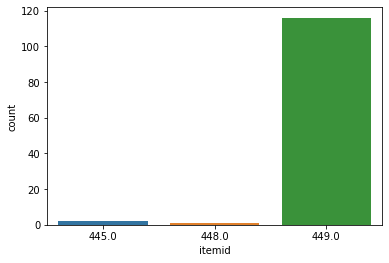

In [30]:
sns.countplot(x=df_charts[(df_charts.itemid==445) | (df_charts.itemid==448) | (df_charts.itemid==449)].itemid);

In [31]:
df_charts = exclude(449,448, df_charts)

Shape original dataframe:(73912, 14)
Intersection: 0, Symmetric difference: 1
Shape new dataframe:(73912, 14)
Deleted intersecting rows:0


In [32]:
df_charts = exclude(449,445, df_charts)

Shape original dataframe:(73912, 14)
Intersection: 1, Symmetric difference: 1
Shape new dataframe:(73911, 14)
Deleted intersecting rows:1


**Metavision**

In [33]:
df_items[(df_items.ITEMID==224687) | (df_items.ITEMID==1340) | (df_items.ITEMID==1486) | (df_items.ITEMID==1600)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1225,1354,1340,high minute volume,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2757,2941,1486,High Minute Volume,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2867,3051,1600,HIGH MINUTE VOLUME,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
10051,13243,224687,Minute Volume,Minute Volume,metavision,chartevents,Respiratory,L/min,Numeric,NaN


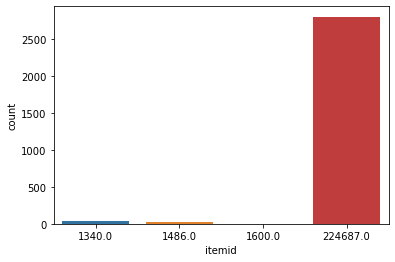

In [34]:
sns.countplot(x=df_charts[(df_charts.itemid==224687) | (df_charts.itemid==1340) | (df_charts.itemid==1486) | (df_charts.itemid==1600)].itemid);

they seem to be different measurements 

In [35]:
df_charts = df_charts[df_charts.itemid != 1340]
df_charts = df_charts[df_charts.itemid != 1486]
df_charts = df_charts[df_charts.itemid != 1600]

In [36]:
df_charts.shape

(73836, 14)

# FiO2

Source|values
:---|:---
cv| 189, 190, 3420, 3422
mv|223835

In [37]:
df_items[(df_items.ITEMID==189) | (df_items.ITEMID==190) | (df_items.ITEMID==3420) | (df_items.ITEMID==3422)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
453,190,189,FiO2 (Analyzed),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
454,191,190,FiO2 Set,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1838,1019,3420,FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1840,1021,3422,FIO2 [Meas],NaN,carevue,chartevents,NaN,NaN,NaN,NaN


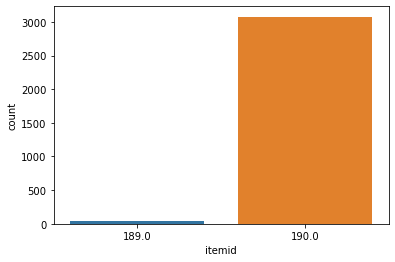

In [38]:
sns.countplot(x=df_charts[(df_charts.itemid==189) | (df_charts.itemid==190) | (df_charts.itemid==3420) | (df_charts.itemid==3422)].itemid);

In [39]:
df_charts = exclude(190,189, df_charts)

Shape original dataframe:(73836, 14)
Intersection: 7, Symmetric difference: 31
Shape new dataframe:(73829, 14)
Deleted intersecting rows:7


# Tidal Volume

Source|values
:---|:---
cv|681,682, 683, 684 
mv|224685, 224684, 224686

**Carevue**

In [40]:
df_items[(df_items.ITEMID==681) | (df_items.ITEMID==682) | (df_items.ITEMID==683) | (df_items.ITEMID==684)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1451,632,681,Tidal Volume,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1452,633,682,Tidal Volume (Obser),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1453,634,683,Tidal Volume (Set),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1454,635,684,Tidal Volume (Spont),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


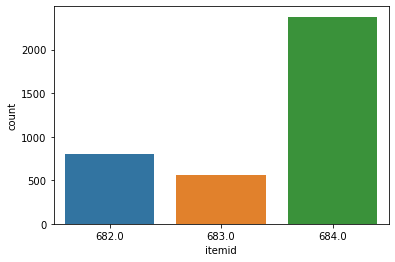

In [41]:
sns.countplot(x=df_charts[(df_charts.itemid==681) | (df_charts.itemid==682) | (df_charts.itemid==683) | (df_charts.itemid==684)].itemid);

In [42]:
df_charts = exclude(684,683, df_charts)

Shape original dataframe:(73829, 14)
Intersection: 119, Symmetric difference: 446
Shape new dataframe:(73710, 14)
Deleted intersecting rows:119


In [43]:
df_charts = exclude(684,682, df_charts)

Shape original dataframe:(73710, 14)
Intersection: 511, Symmetric difference: 285
Shape new dataframe:(73199, 14)
Deleted intersecting rows:511


**Metavision**

In [44]:
df_items[(df_items.ITEMID==224685) | (df_items.ITEMID==224684) | (df_items.ITEMID==224686)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
10048,13240,224684,Tidal Volume (set),Tidal Volume (set),metavision,chartevents,Respiratory,mL,Numeric,NaN
10049,13241,224685,Tidal Volume (observed),Tidal Volume (observed),metavision,chartevents,Respiratory,mL,Numeric,NaN
10050,13242,224686,Tidal Volume (spontaneous),Tidal Volume (spontaneous),metavision,chartevents,Respiratory,mL,Numeric,NaN


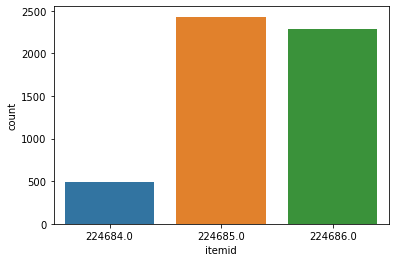

In [45]:
sns.countplot(x=df_charts[(df_charts.itemid==224685) | (df_charts.itemid==224684) | (df_charts.itemid==224686)].itemid);

In [46]:
df_charts = exclude(224685,224684, df_charts)

Shape original dataframe:(73199, 14)
Intersection: 440, Symmetric difference: 48
Shape new dataframe:(72759, 14)
Deleted intersecting rows:440


In [47]:
df_charts = exclude(224685,224686, df_charts)

Shape original dataframe:(72759, 14)
Intersection: 1947, Symmetric difference: 336
Shape new dataframe:(70812, 14)
Deleted intersecting rows:1947


# Leuko

In [48]:
df_items[(df_items.ITEMID==1127) | (df_items.ITEMID==861) | (df_items.ITEMID==1542)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
120,1272,1127,"WBC (4-11,000)",NaN,carevue,chartevents,Hematology,NaN,NaN,NaN
772,1149,861,"WBC (4-11,000)",NaN,carevue,chartevents,Hematology,NaN,NaN,NaN
2810,2994,1542,WBC,NaN,carevue,chartevents,Hematology,NaN,NaN,NaN


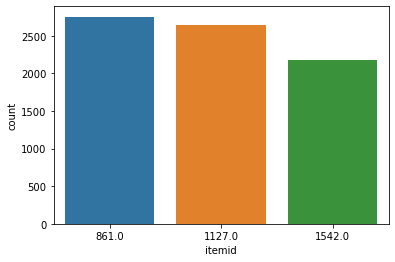

In [49]:
sns.countplot(x=df_charts[(df_charts.itemid==1127) | (df_charts.itemid==861) | (df_charts.itemid==1542)].itemid);

In [50]:
df_charts = exclude(861, 1127, df_charts)

Shape original dataframe:(70812, 14)
Intersection: 2642, Symmetric difference: 0
Shape new dataframe:(68170, 14)
Deleted intersecting rows:2642


In [51]:
df_charts = exclude(861, 1542, df_charts)

Shape original dataframe:(68170, 14)
Intersection: 2181, Symmetric difference: 0
Shape new dataframe:(65989, 14)
Deleted intersecting rows:2181


# Lactic Acid

In [52]:
df_items[(df_items.ITEMID==1531) | (df_items.ITEMID==818)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1556,737,818,Lactic Acid(0.5-2.0),NaN,carevue,chartevents,Chemistry,NaN,NaN,NaN
2799,2983,1531,Lactic Acid,NaN,carevue,chartevents,Chemistry,NaN,NaN,NaN


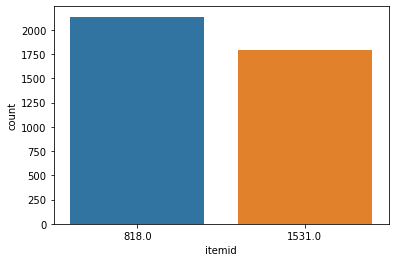

In [53]:
sns.countplot(x=df_charts[(df_charts.itemid==1531) | (df_charts.itemid==818)].itemid);

In [54]:
df_charts = exclude(818, 1531, df_charts)

Shape original dataframe:(65989, 14)
Intersection: 1795, Symmetric difference: 0
Shape new dataframe:(64194, 14)
Deleted intersecting rows:1795


# Comparison

In [55]:
f'We have {first_shape[0]-df_charts.shape[0]} less rows'

'We have 10112 less rows'

In [56]:
# Number of unique values from itemid
f'We have {df_charts.itemid.nunique()} instead of  {first_unique} unique values'

'We have 24 instead of  44 unique values'

In [57]:
df_charts.shape

(64194, 14)

In [58]:
df_charts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64194 entries, 0 to 74163
Data columns (total 14 columns):
hadm_id         64194 non-null float64
icustay_id      64194 non-null float64
itemid          64194 non-null float64
charttime       64194 non-null object
value           63893 non-null object
valuenum        63972 non-null float64
valueuom        56302 non-null object
item            64194 non-null object
storetime       64114 non-null object
cgid            64114 non-null float64
warning         31251 non-null float64
error           31251 non-null float64
resultstatus    5011 non-null object
stopped         32943 non-null object
dtypes: float64(7), object(7)
memory usage: 7.3+ MB


## create new csv file

In [60]:
df_charts.to_csv('./data/chartevents_new.csv', index = False)